# 实验报告
<font size=4>
小组成员:

+ **洪崇晏**  **2114038**
+ **于成俊**  **2112066**
+ **曹昕城**  **2111446**
+ **庞天傲**  **2113495**
+ **李佳音**  **2111093**


</font>

## 实验要求

<font size=4>
题目：基于深度学习的细胞类型聚类
    
    
1. 基本要求(20)：使用简单的深度学习的方法对数据进行细胞类型聚类，得到多个亚群，完成实验报告（最好使用ipynb文件，包括但不限于代码、模型设计思路、模型架构图、聚类效果展示、实验分析等），并以csv文件提交最终的dataset1数据聚类结果（聚类编号从0到k，k为算法计算的k个潜在细胞群）。
2. 中级要求(5)：使用你的方法在dataset2上做实验，dataset2有真实的细胞类型标签，你可以对你的方法进行自我评估，并且分析结果，可以体现你的模型改进过程。展示你计算的Adjusted Rand Score指标。
3. 高级要求(5)：使用较为复杂的神经网络进行细胞类型聚类。如复现相关论文，用到你的网络中进行复现等。
4. 加分项(5):基础要求的结果会通过Adjusted Rand Score指标进行评分，排名靠前会有额外得分。
</font>

## 模型设计思路
+ 编码器（Encoder）：

nn.Linear(input_dim, hidden_dim)：输入层到隐藏层的线性变换，将输入数据投影到低维空间。
nn.ReLU()：使用 ReLU 激活函数进行非线性变换，引入非线性特征。

+ 解码器（Decoder）：

nn.Linear(hidden_dim, input_dim)：隐藏层到输出层的线性变换，将隐藏表示映射回原始输入维度。
nn.ReLU()：使用 ReLU 激活函数进行非线性变换，帮助还原原始数据。

+ 前向传播（Forward）：

forward(self, x) 方法定义了自编码器的前向传播过程。在前向传播中，输入数据经过编码器产生编码表示，然后通过解码器进行解码，得到重构的输出。

+ 目标（Objective）：

自编码器的目标是最小化输入与输出之间的差异，即重构误差。在这里，由于使用了 ReLU 激活函数，输出值的范围通常是 [0, 正无穷)，因此均方误差（MSE）是一个合适的损失函数。

## 模型架构图
下面是自编码器模型的模型架构图：

<img src="https://img1.imgtp.com/2024/01/19/HbXKV8E6.jpg" style="zoom:40%" />

## 基本要求和中级要求

1.导入相关包，忽略掉警告（防止输出混乱）

In [111]:
#导入所需要的包
import numpy as np
import torch
import scanpy as sc
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp
from sklearn.decomposition import PCA
import warnings
#忽略所有警告
warnings.filterwarnings("ignore")

2.加载dataset2.h5ad数据并进行预处理

In [113]:
#指定文件路径
file_path = "/content/dataset2.h5ad"
adata = sc.read_h5ad(file_path)
# 提取每个细胞的真实细胞类型标签,并将其转换为 NumPy 数组
cell_type_array = adata.obs['cell_type'].to_numpy()
# 计算有多少种细胞
num_cell_types = adata.obs['cell_type'].nunique()
#将稀疏矩阵转换为密集矩阵
adata = adata.X.todense()
adata = np.asarray(adata)
# 对数变换
adata = np.log1p(adata)
# 标准化
scaler = StandardScaler()
adata = scaler.fit_transform(adata)
# 归一化
minmax_scaler = MinMaxScaler()
adata = minmax_scaler.fit_transform(adata)
# PCA降维
pca = PCA(n_components=40)
adata = pca.fit_transform(adata)
# 将数据转换为PyTorch张量
X_tensor = torch.tensor(adata, dtype=torch.float32)

3.构建简单的自编码器模型

In [114]:
#构建简单的自编码器模型
class Autoencoder(nn.Module):
    #在初始化阶段定义了编码器和解码器的结构。编码器和解码器都是由一个线性层（全连接层）和激活函数 ReLU 组成的序列。
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )
    #定义了数据在模型中的前向传播过程,输入数据经过编码器和解码器的处理后返回解码后的输出
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

4.训练模型

In [115]:
#训练模型

input_dim = X_tensor.shape[1]
hidden_dim =128  # 隐藏层维度可调整
# 定义编码器和解码器的结构，并初始化了整个自编码器模型
model = Autoencoder(input_dim, hidden_dim)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
#创建 Adam 优化器，用于优化自编码器模型的参数。model.parameters() 用于获取模型中的所有参数，lr=1e-4 是学习率的设置
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# 定义均方误差 MSE 损失函数, 用于衡量模型输出与输入之间的重构误差
criterion = nn.MSELoss()
num_epochs = 500 # 根据需要调整训练轮次
for epoch in range(num_epochs):
    # 前向传播
    output = model(X_tensor)
    loss = criterion(output, X_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.3726
Epoch [20/500], Loss: 0.3670
Epoch [30/500], Loss: 0.3619
Epoch [40/500], Loss: 0.3570
Epoch [50/500], Loss: 0.3524
Epoch [60/500], Loss: 0.3480
Epoch [70/500], Loss: 0.3437
Epoch [80/500], Loss: 0.3395
Epoch [90/500], Loss: 0.3353
Epoch [100/500], Loss: 0.3312
Epoch [110/500], Loss: 0.3271
Epoch [120/500], Loss: 0.3230
Epoch [130/500], Loss: 0.3190
Epoch [140/500], Loss: 0.3150
Epoch [150/500], Loss: 0.3110
Epoch [160/500], Loss: 0.3071
Epoch [170/500], Loss: 0.3032
Epoch [180/500], Loss: 0.2992
Epoch [190/500], Loss: 0.2953
Epoch [200/500], Loss: 0.2914
Epoch [210/500], Loss: 0.2875
Epoch [220/500], Loss: 0.2837
Epoch [230/500], Loss: 0.2799
Epoch [240/500], Loss: 0.2762
Epoch [250/500], Loss: 0.2726
Epoch [260/500], Loss: 0.2690
Epoch [270/500], Loss: 0.2654
Epoch [280/500], Loss: 0.2619
Epoch [290/500], Loss: 0.2585
Epoch [300/500], Loss: 0.2551
Epoch [310/500], Loss: 0.2518
Epoch [320/500], Loss: 0.2486
Epoch [330/500], Loss: 0.2454
Epoch [340/500], Lo

5.编码数据

In [116]:
#编码数据
model.eval()
with torch.no_grad():
    X_encoded = model.encoder(X_tensor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))).cpu().numpy()

6.聚类

In [117]:
#聚类#
from sklearn.metrics import adjusted_rand_score
# 聚类数量
n_clusters = num_cell_types
# 创建了一个K均值聚类器的实例
kmeans = KMeans(n_clusters=n_clusters)
# 使用K均值聚类器对输入数据X_encoded进行聚类
cluster_labels = kmeans.fit_predict(X_encoded)
# 计算Adjusted Rand Score
ari = adjusted_rand_score(cell_type_array, cluster_labels)
# 打印Adjusted Rand Score
print(f"Adjusted Rand Score: {ari}")

Adjusted Rand Score: 0.13493395909489103


7.改进自编码模型

In [118]:
# 改进的自编码器模型
class ImprovedAutoencoder(nn.Module):
    #在初始化阶段定义了编码器和解码器的结构。编码器和解码器都是由一个线性层（全连接层）和激活函数 ReLU 组成的序列。
    def __init__(self, input_dim, hidden_dim):
        super(ImprovedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)  # 添加 Batch Normalization
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # 使用 Sigmoid 激活函数
        )
        self.dropout = nn.Dropout(0.05)  # 添加 Dropout，可以调整丢弃率
    #定义了数据在模型中的前向传播过程,输入数据经过编码器和解码器的处理后返回解码后的输出
    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)  # 在编码器的输出后应用 Dropout
        x = self.decoder(x)
        return x

8.训练改进后的模型

In [119]:
#训练模型
input_dim = X_tensor.shape[1] # 输入维度, 即单细胞数据的维度
hidden_dims = 128 # 隐藏层维度
# 定义编码器和解码器的结构，并初始化了整个自编码器模型
model = ImprovedAutoencoder(input_dim, hidden_dims)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) # 将模型移动到 GPU 设备(如果可用),否则将其放在 CPU 上进行训练
#创建 Adam 优化器，用于优化自编码器模型的参数。model.parameters() 用于获取模型中的所有参数，lr=1e-4 是学习率的设置
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# 定义均方误差 MSE 损失函数, 用于衡量模型输出与输入之间的重构误差
criterion = nn.MSELoss()
# 设置训练轮次，即模型将遍历整个数据集的次数
epochs = 500  # 根据需要调整训练轮次
for epoch in range(num_epochs):
    # 前向传播
    output = model(X_tensor)
    loss = criterion(output, X_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.6544
Epoch [20/500], Loss: 0.6465
Epoch [30/500], Loss: 0.6389
Epoch [40/500], Loss: 0.6313
Epoch [50/500], Loss: 0.6238
Epoch [60/500], Loss: 0.6161
Epoch [70/500], Loss: 0.6090
Epoch [80/500], Loss: 0.6021
Epoch [90/500], Loss: 0.5956
Epoch [100/500], Loss: 0.5891
Epoch [110/500], Loss: 0.5833
Epoch [120/500], Loss: 0.5776
Epoch [130/500], Loss: 0.5723
Epoch [140/500], Loss: 0.5673
Epoch [150/500], Loss: 0.5624
Epoch [160/500], Loss: 0.5580
Epoch [170/500], Loss: 0.5540
Epoch [180/500], Loss: 0.5497
Epoch [190/500], Loss: 0.5458
Epoch [200/500], Loss: 0.5419
Epoch [210/500], Loss: 0.5383
Epoch [220/500], Loss: 0.5346
Epoch [230/500], Loss: 0.5313
Epoch [240/500], Loss: 0.5278
Epoch [250/500], Loss: 0.5242
Epoch [260/500], Loss: 0.5211
Epoch [270/500], Loss: 0.5174
Epoch [280/500], Loss: 0.5140
Epoch [290/500], Loss: 0.5107
Epoch [300/500], Loss: 0.5077
Epoch [310/500], Loss: 0.5042
Epoch [320/500], Loss: 0.5007
Epoch [330/500], Loss: 0.4975
Epoch [340/500], Lo

9.重新编码数据

In [120]:
#编码数据
model.eval()
with torch.no_grad():
    X_encoded = model.encoder(X_tensor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))).cpu().numpy()

10.重新聚类

In [121]:
#聚类
from sklearn.metrics import adjusted_rand_score
# 聚类数量
n_clusters = num_cell_types
# 创建了一个K均值聚类器的实例
kmeans = KMeans(n_clusters=n_clusters)
# 使用K均值聚类器对输入数据X_encoded进行聚类
cluster_labels = kmeans.fit_predict(X_encoded)
# 计算Adjusted Rand Score
ari = adjusted_rand_score(cell_type_array, cluster_labels)
# 打印Adjusted Rand Score
print(f"Adjusted Rand Score: {ari}")

Adjusted Rand Score: 0.2509526569937523


绘制聚类结果:

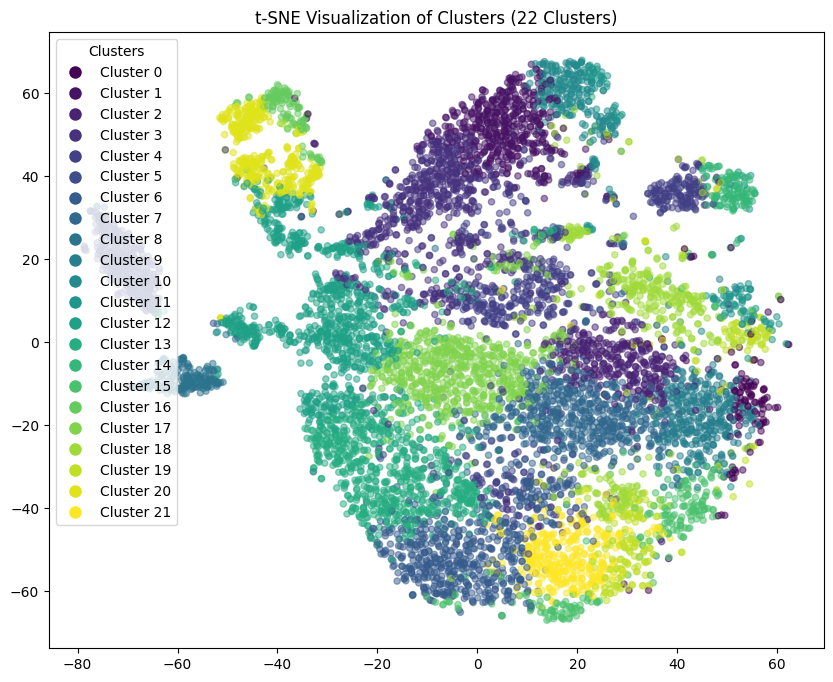

In [122]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

# 绘制散点图，为每个簇分配唯一的颜色
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.5)

# 添加图例，显示每个簇的标签
unique_labels = list(set(cluster_labels))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]
plt.legend(handles=handles, title='Clusters')

plt.title(f't-SNE Visualization of Clusters ({len(set(cluster_labels))} Clusters)')
plt.show()

11.加载dataset1.h5ad数据并进行预处理

In [123]:
#指定文件路径
file_path = "/content/dataset1.h5ad"
adata = sc.read_h5ad(file_path)
#将稀疏矩阵转换为密集矩阵
adata = adata.X.todense()
adata = np.asarray(adata)
# 对数变换
adata = np.log1p(adata)
# 标准化
scaler = StandardScaler()
adata = scaler.fit_transform(adata)
# 归一化
minmax_scaler = MinMaxScaler()
adata = minmax_scaler.fit_transform(adata)
# PCA降维
pca = PCA(n_components=40)
adata = pca.fit_transform(adata)
# 将数据转换为PyTorch张量
X_tensor = torch.tensor(adata, dtype=torch.float32)

12.训练模型

In [124]:
#训练模型
input_dim = X_tensor.shape[1] #输入维度, 即单细胞数据的维度
hidden_dim =128  # 隐藏层维度可调整
# 定义编码器和解码器的结构，并初始化了整个自编码器模型
model = ImprovedAutoencoder(input_dim, hidden_dims)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
#创建 Adam 优化器，用于优化自编码器模型的参数。model.parameters() 用于获取模型中的所有参数，lr=1e-4 是学习率的设置
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# 定义均方误差 MSE 损失函数, 用于衡量模型输出与输入之间的重构误差
criterion = nn.MSELoss()
num_epochs = 500 # 根据需要调整训练轮次
for epoch in range(num_epochs):
    # 前向传播
    output = model(X_tensor)
    loss = criterion(output, X_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 打印损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 1.1788
Epoch [20/500], Loss: 1.1678
Epoch [30/500], Loss: 1.1563
Epoch [40/500], Loss: 1.1448
Epoch [50/500], Loss: 1.1332
Epoch [60/500], Loss: 1.1220
Epoch [70/500], Loss: 1.1107
Epoch [80/500], Loss: 1.1000
Epoch [90/500], Loss: 1.0892
Epoch [100/500], Loss: 1.0788
Epoch [110/500], Loss: 1.0687
Epoch [120/500], Loss: 1.0594
Epoch [130/500], Loss: 1.0506
Epoch [140/500], Loss: 1.0422
Epoch [150/500], Loss: 1.0343
Epoch [160/500], Loss: 1.0268
Epoch [170/500], Loss: 1.0193
Epoch [180/500], Loss: 1.0127
Epoch [190/500], Loss: 1.0061
Epoch [200/500], Loss: 0.9998
Epoch [210/500], Loss: 0.9941
Epoch [220/500], Loss: 0.9882
Epoch [230/500], Loss: 0.9827
Epoch [240/500], Loss: 0.9773
Epoch [250/500], Loss: 0.9721
Epoch [260/500], Loss: 0.9671
Epoch [270/500], Loss: 0.9620
Epoch [280/500], Loss: 0.9572
Epoch [290/500], Loss: 0.9524
Epoch [300/500], Loss: 0.9481
Epoch [310/500], Loss: 0.9434
Epoch [320/500], Loss: 0.9388
Epoch [330/500], Loss: 0.9347
Epoch [340/500], Lo

13.编码数据

In [125]:
#编码数据
model.eval()
with torch.no_grad():
    X_encoded = model.encoder(X_tensor.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))).cpu().numpy()

14.聚类个数决策

In [126]:
#聚类个数决策
#因为dataset1中不知道真实的标签，也就意味着不知道真实的聚类个数，需要得到合适的个数进行聚类
#使用轮廓系数和Calinski-Harabasz指数来判断聚类的个数
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

for num_clusters in range(15, 26):  # 测试聚类数从 15 到 25
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(X_encoded)

    silhouette_avg = silhouette_score(X_encoded, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X_encoded, cluster_labels)

    print(f'For n_clusters = {num_clusters}, Silhouette Score: {silhouette_avg}, Calinski-Harabasz Index: {calinski_harabasz}')


For n_clusters = 15, Silhouette Score: 0.17216280102729797, Calinski-Harabasz Index: 1088.8376530471085
For n_clusters = 16, Silhouette Score: 0.16777577996253967, Calinski-Harabasz Index: 1052.303106947226
For n_clusters = 17, Silhouette Score: 0.1514987051486969, Calinski-Harabasz Index: 1020.1096006610579
For n_clusters = 18, Silhouette Score: 0.165928915143013, Calinski-Harabasz Index: 994.2707100864365
For n_clusters = 19, Silhouette Score: 0.16002459824085236, Calinski-Harabasz Index: 959.833253529383
For n_clusters = 20, Silhouette Score: 0.14137710630893707, Calinski-Harabasz Index: 931.2230765082805
For n_clusters = 21, Silhouette Score: 0.1377430260181427, Calinski-Harabasz Index: 901.9755085803041
For n_clusters = 22, Silhouette Score: 0.13265812397003174, Calinski-Harabasz Index: 878.1960003303268
For n_clusters = 23, Silhouette Score: 0.1302838921546936, Calinski-Harabasz Index: 853.1886247976694
For n_clusters = 24, Silhouette Score: 0.1291474550962448, Calinski-Harabasz 

15.对dataset1进行聚类，并将结果输出到cluster_labels.csv文件

In [127]:
n_clusters = 15 # 聚类数量由轮廓系数和Calinski-Harabasz指数得到15或16
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(X_encoded)
# 保存聚类标签到 CSV 文件
np.savetxt("cluster_labels.csv", cluster_labels, delimiter=",", fmt='%d')

绘制聚类结果：

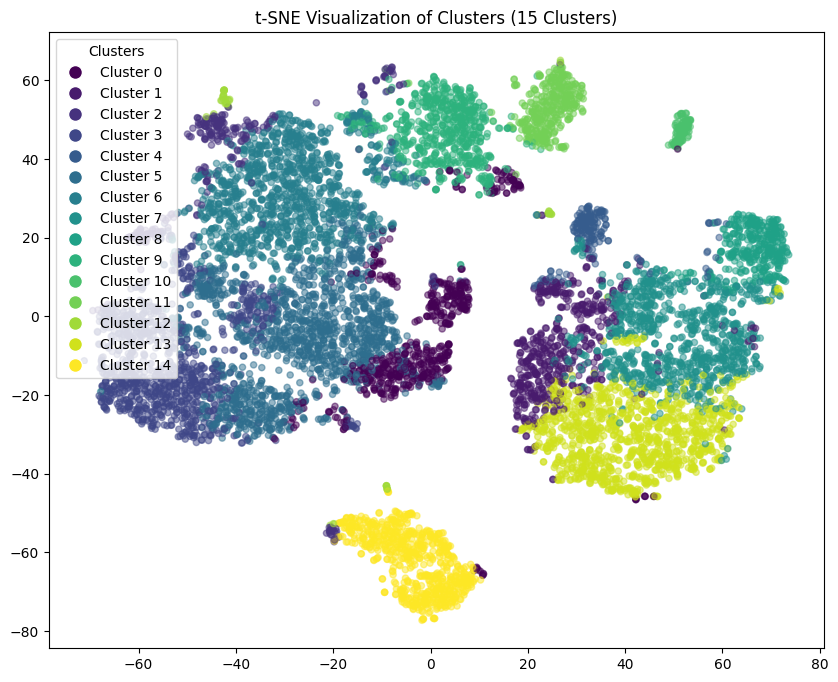

In [128]:
# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

# 绘制散点图，为每个簇分配唯一的颜色
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.5)

# 添加图例，显示每个簇的标签
unique_labels = list(set(cluster_labels))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]
plt.legend(handles=handles, title='Clusters')

plt.title(f't-SNE Visualization of Clusters ({len(set(cluster_labels))} Clusters)')
plt.show()

## 高级要求

复现论文：Clustering single-cell RNA-seq data with a model-based deep learning approach

### （1）论文介绍

这是2019年发表于nature子刊machine intelligence的一篇论文，作者是Tian Tian , Ji Wan, Qi Song and Zhi Wei。论文主要是提出了一个新的框架scDeepCluster，利用自编码器对单细胞RNA测序数据进行降噪分类，以及在二维平面图进行可视化。在该框架中，基于ZINB模型的自动编码器学习率将scRNA-seq数据的读取计数矩阵映射到低维潜在表示的非线性函数，而在潜在空间上的聚类任务是通过kullback聚类执行的KL散度的深度嵌入算法（DEC）实现的。scDeepCluster的计算效率高，这更加适合用于大型单细胞转录组数据集的分析。其模型图如下：

<img src="https://img1.imgtp.com/2024/01/19/ydaunZPS.png" style="zoom:40%" />

其中的深度嵌入算法（DEC）是一种使用深度神经网络(一般为自编码网络)，同时学习特征表示和聚类分配的方法。 DEC 学习了从数据空间到低维特征空间的映射，并在该特征空间中迭代地优化聚类目标。它的算法大致如下：

考虑将n个点$x_i$的集合聚类为$k$个类的问题，每个聚类由质心$\mu_i$表示。

DEC 首先使用非线性映射$f_\theta:X->Z$变换数据，而不是直接在数据空间$X$中进行聚类。

其中$\theta$是可学习的参数，$Z$是潜在特征空间。 $Z$的维度通常比$X$小得多，以避免"维度诅咒"。

为了对映射$f_\theta$进行参数化，深层神经网络(Deep Neural Network, DNN)由于其理论函数逼近特性和已证明的特征学习能力而成为最好的选择。

DEC 算法通过同时学习特征空间$Z$中的$k$个聚类中心$\mu_j$和将数据点映射到$Z$的 DNN 参数$\theta$来对数据进行聚类。

DEC有两个阶段：

1. 预训练深度自编码器进行参数初始化(参数包括网络参数$\theta$和聚类质心$\left\{\mu_j\right\}_{j=1}^k$
2. 参数优化(即聚类)：选取 AE 模型中的 Encoder 部分，加入聚类层，迭代优化辅助目标分布与聚类分配的 KL 散度。

### （2）环境配置

python和各种安装包的版本如下：


<img src="https://img1.imgtp.com/2024/01/19/C96TsD3p.png" style="zoom:40%" />

### （3）代码实现

整个模型最开始用ZINB损失函数预处理，然后利用k-means算法在潜在层初始化特征得到聚类中心，对Encoder部分使用聚类公式。

1.导入相关包

In [78]:
from time import time
import numpy as np
import keras.backend as K
import tensorflow as tf
from keras.layers import InputSpec
from keras.layers import Dense, Input, GaussianNoise, Layer, Activation
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn import metrics
import csv, os
import h5py
import scanpy as sc
import warnings
from tensorflow.python.framework.ops import disable_eager_execution
#忽略所有警告
warnings.filterwarnings("ignore")
#禁用 TensorFlow 的即时执行模式
disable_eager_execution()

2.构建自编码器

自编码器中对输入单细胞RNA测序数据进行降噪的公式是

<img src="https://img1.imgtp.com/2024/01/19/lPmOVvq0.png" style="zoom:40%" />

创建相关基础函数

In [79]:
# 将输入张量中的 NaN 值替换为零
def _nan2zero(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
# 将输入张量中的 NaN 值替换为正无穷
def _nan2inf(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x) + np.inf, x)
# 计算张量中非 NaN 元素的数量
def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.math.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)
# 计算张量的均值，忽略 NaN 值
def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)
# 计算均方误差损失，忽略 NaN 值
def mse_loss(y_true, y_pred):
    ret = tf.square(y_pred - y_true)
    return _reduce_mean(ret)

构建负二项损失类NB

In [80]:
class NB(object):
    def __init__(self, theta=None, masking=False, scope='nbinom_loss/',
                 scale_factor=1.0, debug=False):
        """
        负二项损失类的初始化方法。

        参数：
        - theta: 泊松分布的超参数。
        - masking: 是否使用掩码。
        - scope: TensorFlow 变量作用域的名称。
        - scale_factor: 缩放因子。
        - debug: 是否启用调试模式。
        """
        # 用于数值稳定性的小值
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.scope = scope
        self.masking = masking
        self.theta = theta

    def loss(self, y_true, y_pred, mean=True):
        """
        计算负二项损失。

        参数：
        - y_true: 真实值张量。
        - y_pred: 预测值张量。
        - mean: 是否计算平均损失。

        返回：
        - 负二项损失。
        """
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            # 将输入张量转换为 float32 类型
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor

            if self.masking:
                # 如果使用掩码，计算非 NaN 值的元素个数
                nelem = _nelem(y_true)
                # 将 NaN 值替换为零
                y_true = _nan2zero(y_true)

            # 限制 theta 的最大值
            theta = tf.minimum(self.theta, 1e6)

            # 计算负二项分布损失的两个部分
            t1 = tf.math.lgamma(theta + eps) + tf.math.lgamma(y_true + 1.0) - tf.math.lgamma(y_true + theta + eps)
            t2 = (theta + y_true) * tf.math.log(1.0 + (y_pred / (theta + eps))) + (
                        y_true * (tf.math.log(theta + eps) - tf.math.log(y_pred + eps)))

            if self.debug:
                # 在调试模式下，添加数值检查操作
                assert_ops = [
                    tf.debugging.check_numerics(y_pred, 'y_pred has inf/nans'),
                    tf.debugging.check_numerics(t1, 't1 has inf/nans'),
                    tf.debugging.check_numerics(t2, 't2 has inf/nans')
                ]

                # 将 t1 和 t2 的直方图添加到 TensorBoard 摘要
                tf.summary.histogram('t1', t1)
                tf.summary.histogram('t2', t2)

                with tf.control_dependencies(assert_ops):
                    final = t1 + t2

            else:
                final = t1 + t2

            # 将 NaN 替换为正无穷
            final = _nan2inf(final)

            if mean:
                # 如果需要计算平均损失
                if self.masking:
                    # 使用掩码时，计算总损失并除以非 NaN 元素个数
                    final = tf.divide(tf.reduce_sum(final), nelem)
                else:
                    # 不使用掩码时，直接计算平均损失
                    final = tf.reduce_mean(final)

        return final

基于NB类,构造ZINB损失类

In [81]:
class ZINB(NB):
    def __init__(self, pi, ridge_lambda=0.0, scope='zinb_loss/', **kwargs):
        """
        Zero-Inflated Negative Binomial (ZINB) 损失类的初始化方法。

        参数：
        - pi: 表示零膨胀分量的概率。
        - ridge_lambda: 正则化参数。
        - scope: TensorFlow 变量作用域的名称。
        - kwargs: 其他参数，会传递给父类 NB 的初始化方法。
        """
        super().__init__(scope=scope, **kwargs)
        self.pi = pi
        self.ridge_lambda = ridge_lambda

    def loss(self, y_true, y_pred, mean=True):
        """
        计算 Zero-Inflated Negative Binomial (ZINB) 损失。

        参数：
        - y_true: 真实值张量。
        - y_pred: 预测值张量。
        - mean: 是否计算平均损失。

        返回：
        - ZINB 损失。
        """
        scale_factor = self.scale_factor
        eps = self.eps

        with tf.name_scope(self.scope):
            # 重用 NB 损失计算（均值为 False）
            nb_case = super().loss(y_true, y_pred, mean=False) - tf.math.log(1.0 - self.pi + eps)

            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale_factor
            theta = tf.minimum(self.theta, 1e6)

            zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
            zero_case = -tf.math.log(self.pi + ((1.0 - self.pi) * zero_nb) + eps)
            result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
            ridge = self.ridge_lambda * tf.square(self.pi)
            result += ridge

            if mean:
                if self.masking:
                    result = _reduce_mean(result)
                else:
                    result = tf.reduce_mean(result)

            result = _nan2inf(result)

            if self.debug:
                # 将直方图添加到 TensorBoard 摘要
                tf.summary.histogram('nb_case', nb_case)
                tf.summary.histogram('zero_nb', zero_nb)
                tf.summary.histogram('zero_case', zero_case)
                tf.summary.histogram('ridge', ridge)

        return result

自编码器解码器Decoder部分最后面三层的激活函数如下:

<img src="https://img1.imgtp.com/2024/01/19/gVJ2OnHK.png" style="zoom:40%" />

设置激活函数：

In [82]:
from numpy.random import seed
from tensorflow import random
# 设置随机数生成器的种子为 2211
seed(2211)
# 设置 TensorFlow 随机数生成器的种子为 2211
random.set_seed(2211)
# 该函数将x的指数运算结果裁剪到指定的范围（1e-5 到 1e6 之间）
MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
# 该函数将x的软指数运算结果裁剪到指定的范围（1e-4 到 1e4 之间）
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

定义一个Keras层:

In [83]:
class SliceLayer(Layer):
    '''
    SliceLayer 类，用于从输入列表中提取指定索引的张量。

    参数：
    - index: 要提取的张量的索引。
    - **kwargs: 传递给父类 Layer 初始化的其他关键字参数。
    '''
    def __init__(self, index, **kwargs):
        self.index = index
        super().__init__(**kwargs)

    def build(self, input_shape):
        '''
        在模型构建时验证输入形状是否为列表。

        参数：
        - input_shape: 输入张量的形状（应为列表）。

        返回：无
        '''
        if not isinstance(input_shape, list):
            raise ValueError('Input should be a list')

        super().build(input_shape)

    def call(self, x):
        '''
        定义层的前向传播。

        参数：
        - x: 输入张量列表。

        返回：从列表中提取的指定索引的张量。
        '''
        assert isinstance(x, list), 'SliceLayer input is not a list'
        return x[self.index]

    def compute_output_shape(self, input_shape):
        '''
        计算层的输出形状。

        参数：
        - input_shape: 输入张量的形状（应为列表）。

        返回：从列表中提取的指定索引的张量的形状。
        '''
        return input_shape[self.index]

定义一个Lambda 层:

In [84]:
# Lambda 层，用于按列乘以张量
from keras.layers import Lambda
ColWiseMultLayer = lambda name: Lambda(lambda l: l[0]*(tf.matmul(tf.reshape(l[1], (-1,1)),
                                                                 tf.ones((1, l[0].get_shape()[1]),
                                                                         dtype=l[1].dtype))),
                               name=name)

创建自编码器类:

In [85]:
# 构建对称的全连接自编码器模型。
def autoencoder(dims, noise_sd=0, init='glorot_uniform', act='relu'):
    """
    参数:
        dims: 一个列表，包含编码器每一层的单元数。dims[0] 是输入维度，dims[-1] 是隐藏层的单元数。
             自编码器是对称的，因此自编码器的层数为 2*len(dims)-1。
        noise_sd: 输入层添加高斯噪声的标准差。
        init: 初始化权重的方法。
        act: 激活函数，不应用于输入层、隐藏层和输出层。
    返回:
        自编码器模型
    """
    n_stacks = len(dims) - 1
    # 输入层
    sf_layer = Input(shape=(1,), name='size_factors')
    x = Input(shape=(dims[0],), name='counts')
    h = x
    h = GaussianNoise(noise_sd, name='input_noise')(h)

    # 编码器中的内部层
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], kernel_initializer=init, name='encoder_%d' % i)(h)
        h = GaussianNoise(noise_sd, name='noise_%d' % i)(h)    # 添加高斯噪声
        h = Activation(act)(h)
    # 隐藏层
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_hidden')(h)  # 隐藏层，从这里提取特征

    # 解码器中的内部层
    for i in range(n_stacks-1, 0, -1):
        h = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(h)

    # 输出层
    pi = Dense(dims[0], activation='sigmoid', kernel_initializer=init, name='pi')(h)

    # 使用 DispAct 激活函数处理方差
    disp = Dense(dims[0], activation=DispAct, kernel_initializer=init, name='dispersion')(h)

    # 使用 MeanAct 激活函数处理均值
    mean = Dense(dims[0], activation=MeanAct, kernel_initializer=init, name='mean')(h)

    # 使用 ColWiseMultLayer 和 SliceLayer 处理输出
    output = ColWiseMultLayer(name='output')([mean, sf_layer])
    output = SliceLayer(0, name='slice')([output, disp, pi])

    return Model(inputs=[x, sf_layer], outputs=output)

3.构建聚类层

在潜在层对数据进行聚类的公式是:

<img src="https://img1.imgtp.com/2024/01/19/oinPrjlW.png" style="zoom:40%" />

这个聚类层用于将输入样本转换为软标签，表示每个样本属于每个聚类的概率，并使用学生 t-分布进行概率计算。

其中重要的思想是软分配：基于 t-SNE 的思想，DEC 使用学生t-分布(Student's t-distribution，简称 t-分布)，作为核来测量嵌入点和质心间的相似度：

<img src="https://img1.imgtp.com/2024/01/19/83qVJV2m.png" style="zoom:40%" />

其中，$z_i=f_{\theta}(x_i)\in Z$ 对应于嵌入后的$x_i\in Z$，$\alpha$是 t 分布的自由度，通常设为1.

注意到，$q_{ij}\geq 0$，且$\sum\limits_{j}{q_{ij}}=1$，可解释为将样本$i$分配给簇$j$的概率(即软分配)。 最终的聚类结果选取为$j^{'}=argmax_jq_{ij}$，即属于每个簇的概率中，概率最大的簇。

基于上，我们定义了聚类层类，其中最重要的是call函数。

In [86]:
# 聚类层类: 用于将输入样本转换为软标签，表示每个样本属于每个聚类的概率。该层使用学生 t-分布进行概率计算。
class ClusteringLayer(Layer):
    """
    # 参数
        n_clusters: 聚类的数量。
        weights: 形状为 `(n_clusters, n_features)` 的 Numpy 数组列表，表示初始聚类中心。
        alpha: 学生 t-分布中的参数，默认为 1.0。
    # 输入形状
        形状为 `(n_samples, n_features)` 的 2D 张量。
    # 输出形状
        形状为 `(n_samples, n_clusters)` 的 2D 张量。
    """
    # 构造函数
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        # 检查 kwargs 中是否有 'input_shape'，如果没有但 'input_dim' 在 kwargs 中，则将 'input_shape' 设置为 (kwargs.pop('input_dim'),)
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)


        super(ClusteringLayer, self).__init__(**kwargs)

        # 聚类的数量
        self.n_clusters = n_clusters
        # 学生 t-分布中的参数
        self.alpha = alpha
        # 初始聚类中心的权重
        self.initial_weights = weights
        # 输入规范
        self.input_spec = InputSpec(ndim=2)

    #在构造层时初始化层的权重
    def build(self, input_shape):
        # 确保输入形状是一个包含两个元素的列表
        assert len(input_shape) == 2
        # 获取输入维度
        input_dim = input_shape[1]
        # 设置输入规范
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        # 添加聚类中心的权重

        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')

        # 如果提供了初始权重，则设置权重
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            # 删除初始权重，确保不再使用
            del self.initial_weights
        # 设置构建标志为 True，表示层已构建
        self.built = True

    # 定义了层的前向传播逻辑，即给定输入，计算学生 t-分布，表示样本属于每个聚类的概率。
    def call(self, inputs, **kwargs):
        """
        学生 t-分布，与 t-SNE 算法中使用的相同。
        q_ij = 1/(1+dist(x_i, u_j)^2)，然后进行归一化。
        参数:
            inputs: 包含数据的变量，形状=(n_samples, n_features)
        返回:
            q: 学生 t-分布，或每个样本的软标签，形状=(n_samples, n_clusters)
        """
        # 计算学生 t-分布
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # 对分布进行归一化
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    # 定义了层的输出形状，确保输入形状是一个包含两个元素的列表。
    def compute_output_shape(self, input_shape):
        # 确保输入形状是一个包含两个元素的列表
        assert input_shape and len(input_shape) == 2
        # 返回输出形状，形状=(n_samples, n_clusters)
        return input_shape[0], self.n_clusters

    # 获取层的配置信息，用于保存模型。
    def get_config(self):
        # 获取层的配置信息
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        # 返回合并了基础配置和特定配置的字典
        return dict(list(base_config.items()) + list(config.items()))

4.创建SCDeepCluster类，用来实现整个网络

在其构造函数中：

- self.autoencoder 为函数`autoencoder()`返回的自编码网络
- self.encoder 为中间不添加噪声的编码器部分
- self.loss 为 ZINB 损失
- self.model 为 scDeepCluster 的模型，输入为自编码网络的输入(即大小因子和与处理后的基因表达数据)，输出为软分配和去噪结果

其中，预训练是直接端到端训练的，损失 self.loss 为 ZINB 损失。

**模型训练过程**（有三个步骤）:
- 做预训练或读取训练好的参数
- 用 k-means 初始化聚类质心，此时使用的是无噪声添加的编码器 self.encoder 来得到低维表示
- 每隔 update_interval 算一次聚类分配和辅助分布，判断是否要停止训练。每次迭代用的辅助分布 p 是上次 update 时算的，而不是每次迭代都算一遍

代码如下:

In [103]:
# SCDeepCluster类
class SCDeepCluster(object):
    # 构造函数
    def __init__(self,
                 dims,
                 n_clusters=10,
                 noise_sd=0,
                 alpha=1.0,
                 ridge=0,
                 debug=False):

        super(SCDeepCluster, self).__init__()

        # 初始化 SCDeepCluster 模型的参数
        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.noise_sd = noise_sd
        self.alpha = alpha
        self.act = 'relu'
        self.ridge = ridge
        self.debug = debug

        # 构建自编码器模型
        self.autoencoder = autoencoder(self.dims, noise_sd=self.noise_sd, act=self.act)

        # 准备无高斯噪声的编码器模型
        ae_layers = [l for l in self.autoencoder.layers]
        hidden = self.autoencoder.input[0]
        for i in range(1, len(ae_layers)):
            if "noise" in ae_layers[i].name or "dropout" in ae_layers[i].name:
                continue
            else:
                hidden = ae_layers[i](hidden)
            if "encoder_hidden" in ae_layers[i].name:  # 只获取编码器层
                break
        self.encoder = Model(inputs=self.autoencoder.input, outputs=hidden)

        # 获取自编码器中的输出层及其参数
        pi = self.autoencoder.get_layer(name='pi').output
        disp = self.autoencoder.get_layer(name='dispersion').output
        mean = self.autoencoder.get_layer(name='mean').output

        # 构建 ZINB 损失函数
        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss

        # 构建聚类层
        clustering_layer = ClusteringLayer(self.n_clusters, alpha=self.alpha, name='clustering')(hidden)

        # 构建整体模型，包括聚类层和自编码器的输出
        self.model = Model(inputs=[self.autoencoder.input[0], self.autoencoder.input[1]],
                           outputs=[clustering_layer, self.autoencoder.output])

        # 预训练标志
        self.pretrained = False
        # 聚类中心和预测标签
        self.centers = []
        self.y_pred = []

    # 用于预训练自编码器，编译模型、训练模型、保存权重，最后标记为已预训练
    def pretrain(self, x, y, batch_size=256, epochs=200, optimizer='adam', ae_file='ae_weights.h5'):
        # 预训练自编码器
        print('...预训练自编码器...')
        # 编译自编码器模型
        self.autoencoder.compile(loss=self.loss, optimizer=optimizer)
        # 设置早停机制，监视损失，当损失不再减小时提前停止训练
        es = EarlyStopping(monitor="loss", patience=50, verbose=1)
        # 训练自编码器模型
        self.autoencoder.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, callbacks=[es])
        # 保存自编码器的权重
        self.autoencoder.save_weights(ae_file)
        print('预训练权重已保存到 ./' + str(ae_file))
        self.pretrained = True
    # 加载模型权重
    def load_weights(self, weights_path):  # 加载 scDeepCluster 模型的权重
        self.model.load_weights(weights_path)
    # 从聚类层之前提取特征
    def extract_feature(self, x):  # 从聚类层之前提取特征
        return self.encoder.predict(x)
    # 使用聚类层的输出预测聚类标签
    def predict_clusters(self, x):  # 使用聚类层的输出预测聚类标签
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)
    # 计算目标分布 P，用于增强软标签 Q 的判别性
    @staticmethod
    def target_distribution(q):  # 目标分布 P，增强软标签 Q 的判别性
        # 计算权重，用于加强软标签的判别性
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T


    # 训练函数
    def fit(self, x_counts, sf, y, raw_counts, batch_size=256, maxiter=2e4, tol=1e-3, update_interval=140,
            ae_weights=None, save_dir='./results/scDeepCluster', loss_weights=[1, 1], optimizer='adadelta'):
        """
        训练 scDeepCluster 模型。
        参数:
            x_counts: 基因表达数据，形状为 (样本数, 基因数)。
            sf: 大小因子（Size Factor）数据，形状为 (样本数, 1)。
            y: 真实标签，如果无标签则为 None。
            raw_counts: 原始基因表达数据，形状为 (样本数, 基因数)。
            batch_size: 批次大小。
            maxiter: 最大迭代次数。
            tol: 停止训练的容忍度。
            update_interval: 每隔多少次迭代更新辅助目标分布 P。
            ae_weights: 预训练自编码器的权重文件路径。
            save_dir: 模型保存的目录。
            loss_weights: 损失权重，分别对应聚类损失和自编码器损失。
            optimizer: 优化器。

        返回:
            y_pred: 预测的聚类标签。
        """
        # 编译 scDeepCluster 模型
        self.model.compile(loss=['kld', self.loss], loss_weights=loss_weights, optimizer=optimizer)

        print('Update interval', update_interval)
        save_interval = int(x_counts.shape[0] / batch_size) * 5  # 5 个 epochs
        print('Save interval', save_interval)

        # 步骤1：预训练
        if not self.pretrained and ae_weights is None:
            print('...使用默认超参数预训练自编码器:')
            print('   optimizer=\'adam\';   epochs=200')
            self.pretrain(x_counts, batch_size)
            self.pretrained = True
        elif ae_weights is not None:
            self.autoencoder.load_weights(ae_weights)
            print('ae_weights 载入成功.')

        # 步骤2：使用 k-means 初始化聚类中心
        print('使用 k-means 初始化聚类中心.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict([x_counts, sf]))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # 步骤3：深度聚类
        # 日志文件
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/scDeepCluster_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict([x_counts, sf], verbose=0)
                p = self.target_distribution(q)  # 更新辅助目标分布 p

                # 评估聚类性能
                self.y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(cluster_acc(y, self.y_pred), 5)
                    nmi = np.round(metrics.normalized_mutual_info_score(y, self.y_pred), 5)
                    ari = np.round(metrics.adjusted_rand_score(y, self.y_pred), 5)
                    loss = np.round(loss, 5)
                    logwriter.writerow(dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss[0], Lc=loss[1], Lr=loss[2]))
                    print('Iter-%d: ACC= %.4f, NMI= %.4f, ARI= %.4f;  L= %.5f, Lc= %.5f,  Lr= %.5f'
                          % (ite, acc, nmi, ari, loss[0], loss[1], loss[2]))

                # 检查停止条件
                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('达到容忍度阈值，停止训练.')
                    logfile.close()
                    break

            # 在批次上训练
            if (index + 1) * batch_size > x_counts.shape[0]:
                loss = self.model.train_on_batch(x=[x_counts[index * batch_size::], sf[index * batch_size:]],
                                                 y=[p[index * batch_size::], raw_counts[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=[x_counts[index * batch_size:(index + 1) * batch_size],
                                                    sf[index * batch_size:(index + 1) * batch_size]],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    raw_counts[index * batch_size:(index + 1) * batch_size]])
                index += 1

            # 保存中间模型
            if ite % save_interval == 0:
                # 保存 scDeepCluster 模型检查点
                print('保存模型至: ' + save_dir + '/scDeepCluster_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/scDeepCluster_model_' + str(ite) + '.h5')

            ite += 1

        # 保存训练好的模型
        logfile.close()
        print('保存模型至: ' + save_dir + '/scDeepCluster_model_final.h5')
        self.model.save_weights(save_dir + '/scDeepCluster_model_final.h5')

        return self.y_pred

5.数据预处理

定义了两个函数:

In [104]:
import scanpy as sc
import scipy as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
# 用于读取数据集并进行预处理
def read_dataset(adata, transpose=False, test_split=False, copy=False):
    """
    读取数据集并进行预处理。

    参数：
    - adata: AnnData 对象或包含文件路径的字符串。
    - transpose: 是否对数据矩阵进行转置。
    - test_split: 是否进行训练集和测试集的拆分。
    - copy: 是否在处理前复制 AnnData 对象。

    返回：
    - 预处理后的 AnnData 对象。
    """

    # 如果传入的是 AnnData 对象
    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()  # 如果需要复制，进行复制操作
    # 如果传入的是文件路径字符串
    elif isinstance(adata, str):
        adata = sc.read(adata)  # 读取文件路径中的 AnnData 对象
    else:
        raise NotImplementedError  # 其他情况暂不支持

    norm_error = '确保数据集（adata.X）包含未标准化的计数数据。'
    assert 'n_count' not in adata.obs, norm_error

    # 检查数据是否为整数，防止浮点数表示
    if adata.X.size < 50e6:  # 只在数组较小的情况下检查整数
        if sp.sparse.issparse(adata.X):
            assert (adata.X.astype(int) != adata.X).nnz == 0, norm_error
        else:
            assert np.all(adata.X.astype(int) == adata.X), norm_error

    # 如果需要转置
    if transpose:
        adata = adata.transpose()

    # 如果需要进行训练集和测试集拆分
    if test_split:
        # 使用 train_test_split 进行拆分，保持随机性
        train_idx, test_idx = train_test_split(np.arange(adata.n_obs), test_size=0.1, random_state=42)
        spl = pd.Series(['train'] * adata.n_obs)
        spl.iloc[test_idx] = 'test'
        adata.obs['DCA_split'] = spl.values
    else:
        adata.obs['DCA_split'] = 'train'

    # 将 'DCA_split' 列的数据类型转换为 category 类型
    adata.obs['DCA_split'] = adata.obs['DCA_split'].astype('category')

    # 打印预处理信息
    print('### Autoencoder: 成功预处理 {} 个基因和 {} 个细胞。'.format(adata.n_vars, adata.n_obs))

    return adata


# 对 AnnData 对象进行标准化和预处理
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    """
    对 AnnData 对象进行标准化和预处理。

    参数：
    - adata: AnnData 对象。
    - filter_min_counts: 是否过滤掉基因和细胞的最小计数为1的情况。
    - size_factors: 是否进行大小因子的计算和归一化。
    - normalize_input: 是否对输入数据进行归一化。
    - logtrans_input: 是否对输入数据进行对数变换。

    返回：
    - 标准化和预处理后的 AnnData 对象。
    """

    # 如果需要过滤最小计数
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    # 创建原始数据副本
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    # 如果需要计算和归一化大小因子
    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    # 如果需要对输入数据进行对数变换
    if logtrans_input:
        sc.pp.log1p(adata)

    # 如果需要对输入数据进行归一化
    if normalize_input:
        sc.pp.scale(adata)

    return adata

6.运行模型

设置超参数:

In [105]:
    # 设置超参数
    import argparse
    parser = argparse.ArgumentParser(description='train',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--n_clusters', default=20, type=int)  # 聚类的数量
    parser.add_argument('--batch_size', default=256, type=int)  # 批次大小
    parser.add_argument('--data_file', default='/content/10X_PBMC_select_2100.h5')  # 数据文件路径
    parser.add_argument('--maxiter', default=2e4, type=int)  # 最大迭代次数
    parser.add_argument('--pretrain_epochs', default=20, type=int)  # 预训练自编码器的迭代次数
    parser.add_argument('--gamma', default=1, type=float, help='coefficient of clustering loss')
    parser.add_argument('--update_interval', default=0, type=int)  # 辅助目标分布 P 的更新间隔
    parser.add_argument('--tol', default=0.001, type=float)  # 停止训练的容忍度
    parser.add_argument('--ae_weights', default=None)  # 预训练自编码器的权重文件路径
    parser.add_argument('--save_dir', default='/content//scDeepCluster')  # 保存模型的目录
    parser.add_argument('--ae_weight_file', default='/content/ae_weights2.h5')  # 预训练自编码器的权重文件名

    args = parser.parse_known_args()[0]

加载数据集:

In [106]:
    # 加载数据集
    optimizer1 = Adam(amsgrad=True)
    optimizer2 = 'adadelta'

    data_mat = h5py.File(args.data_file)
    x = np.array(data_mat['X'])
    y = np.array(data_mat['Y'])

    # 预处理 scRNA-seq 读数矩阵
    adata = sc.AnnData(x)
    adata.obs['Group'] = y

    adata = read_dataset(adata,
                     transpose=False,
                     test_split=False,
                     copy=True)

    adata = normalize(adata,
                      size_factors=True,
                      normalize_input=True,
                      logtrans_input=True)

    input_size = adata.n_vars

    print(adata.X.shape)
    print(y.shape)

    x_sd = adata.X.std(0)
    x_sd_median = np.median(x_sd)
    print("基因标准差的中位数: %.5f" % x_sd_median)

    if args.update_interval == 0:  # 每个 epoch
        args.update_interval = int(adata.X.shape[0] / args.batch_size)
    print(args)

### Autoencoder: 成功预处理 16653 个基因和 2100 个细胞。
(2100, 16449)
(2100,)
基因标准差的中位数: 0.99976
Namespace(n_clusters=20, batch_size=256, data_file='/content/10X_PBMC_select_2100.h5', maxiter=20000.0, pretrain_epochs=20, gamma=1, update_interval=8, tol=0.001, ae_weights=None, save_dir='/content//scDeepCluster', ae_weight_file='/content/ae_weights2.h5')


创建模型:

In [107]:
    # 定义 scDeepCluster 模型
    scDeepCluster = SCDeepCluster(dims=[input_size, 256, 64, 32], n_clusters=args.n_clusters, noise_sd=2.5)
    print("自编码器概要")
    scDeepCluster.autoencoder.summary()
    print("模型概要")
    scDeepCluster.model.summary()
    t0 = time()

自编码器概要
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 counts (InputLayer)         [(None, 16449)]              0         []                            
                                                                                                  
 input_noise (GaussianNoise  (None, 16449)                0         ['counts[0][0]']              
 )                                                                                                
                                                                                                  
 encoder_0 (Dense)           (None, 256)                  4211200   ['input_noise[0][0]']         
                                                                                                  
 noise_0 (GaussianNoise)     (None, 256)                  0         ['encoder_0[0][0

训练模型并输出结果:

In [ ]:
    # 在进行深度聚类训练之前，预训练自编码器
    if args.ae_weights is None:
        scDeepCluster.pretrain(x=[adata.X, adata.obs.size_factors], y=adata.raw.X, batch_size=args.batch_size, epochs=args.pretrain_epochs, optimizer=optimizer1, ae_file=args.ae_weight_file)

    # 开始聚类，不包括预训练部分的时间。
    scDeepCluster.fit(x_counts=adata.X, sf=adata.obs.size_factors, y=y, raw_counts=adata.raw.X, batch_size=args.batch_size, tol=args.tol, maxiter=args.maxiter,
             update_interval=args.update_interval, ae_weights=args.ae_weights, save_dir=args.save_dir, loss_weights=[args.gamma, 1], optimizer=optimizer2)

    # 展示最终结果
    y_pred = scDeepCluster.y_pred
    acc = np.round(cluster_acc(y, scDeepCluster.y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, scDeepCluster.y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, scDeepCluster.y_pred), 5)
    print('最终结果: ACC= %.4f, NMI= %.4f, ARI= %.4f' % (acc, nmi, ari))
    print('聚类时间: %d 秒.' % int(time() - t0))

由于ADAM安装包版本问题，无法在jupyter lab中将结果展现出来。但是，我们在Pycharm中将结果运行出来了，如下:

<img src="https://img1.imgtp.com/2024/01/19/RbrqYbwG.png" style="zoom:40%" />

本次大作业到此已全部完成